In [1]:
%reset
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import matplotlib
%matplotlib inline

import pickle as pk
import numpy as np
import matplotlib.pyplot as pl
pl.rc('text', usetex=False)
# Palatino
pl.rc('font', family='DejaVu Sans')
import torch

dev = torch.device("cuda")
# torch.cuda.set_device(dev)
import torch.optim as optim
from torch.distributions import MultivariateNormal
from torch.distributions import Normal
# change the root directory for this notebook

root_dir = '/global/cfs/cdirs/lsst/www/shivamp/AR_NPE/'
os.chdir(root_dir)

import sys, os
from nf.combined_models import COMBINED_Model
from nf.all_models import *
from nf.utils_data_prep import *
from tqdm import tqdm
%load_ext autoreload
%autoreload 2




Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [2]:
ji = 0
# ns_d = 128
ns_d = 256
# ns_d = 512
nb = 8
nax_d = ns_d // nb
nf = 3
layers_types = ['cnn', 'res']
nc = 0
for jl in range(len(layers_types)):
    if layers_types[jl] == 'cnn':
        nc += 1
    elif layers_types[jl] == 'res':
        nc += 2
    else:
        raise ValueError("layer type not supported")

# z=127 is the initial condition
z_all = [0, 0.5, 127]
# z_all = [0]
# ns_h = 128
ns_h = 256
nax_h = ns_h // nb

nsims_per_batch = 32
# nbatches_train = nb**3//nsims_per_batch
nbatches_train = 4




In [3]:
print(nbatches_train)


4


In [4]:
hidden_dim_MAF = 5
learning_rate = 0.01
K_M1 = 5
B_M1 = 3
nflows_M1_NSF = 3
K_Mdiff = 5
B_Mdiff = 3
nflows_Mdiff_NSF = 3
base_dist_M1 = 'gumbel'
base_dist_Mdiff = 'gumbel'
ngauss_M1 = 5
changelr = False
ksize = nf
nfeature_cnn = 4
nout_cnn = 4 * nfeature_cnn
ninp = len(z_all)
num_cond = nout_cnn + ninp



In [5]:
# Load the density data
df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train = load_density_halo_data_NGP(
    ji, ns_d, nb, nf, nc, z_all, ns_h, stype='ngp'
    )

# Prepare the density and halo data
return_dict_train = prep_density_halo_cats_batched(
    df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train, nsims=nsims_per_batch,
    nbatches = nbatches_train
    )




0 32
32 64
64 96
96 128


In [6]:
return_dict_train['M1_halos_all_norm'][0].shape
# return_dict_train.keys()


(32, 32768)

In [7]:
model_Ntot = SumGaussModel(
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond,
    ngauss=return_dict_train['ngauss_Nhalo'],
    mu_all=return_dict_train['mu_all'],
    sig_all=return_dict_train['sig_all'],
    # base_dist=None
    base_dist='pl_exp'    
    )
# model_Ntot.to(dev)

model_M1 = NSF_M1_CNNcond(
    K=K_M1,
    B=B_M1,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond + 1,
    nflows=nflows_M1_NSF,
    base_dist=base_dist_M1,
    # mu_pos=False
    mu_pos=True
    )

# model_M1.to(dev)

ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]
model_Mdiff = NSF_Mdiff_CNNcond(
    dim=ndim_diff,
    K=K_Mdiff,
    B=B_Mdiff,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond + 2,
    nflows=nflows_Mdiff_NSF,
    base_dist=base_dist_Mdiff,
    mu_pos=True
    )
model_Mdiff.to(dev)

print()



In [8]:
ndim = ndim_diff + 1
model = COMBINED_Model(
    None,
    model_Mdiff,
    # None,
    model_M1,
    model_Ntot,
    ndim,
    ksize,
    ns_d,
    ns_h,
    nb,
    ninp,
    nfeature_cnn,
    nout_cnn,
    layers_types=layers_types,
    act='tanh',
    padding='valid',
    sep_Ntot_cond=True,
    sep_M1_cond=True,
    sep_Mdiff_cond=True,
    )

model.to(dev)

print()




In [9]:
np.array(return_dict_train['df_d_all']).shape
# np.array(return_dict_train['df_d_all_nsh']).shape


(4, 32, 3, 38, 38, 38)

In [10]:
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_all_it = []
loss_min = 1e20







In [11]:
# cond_tensor = torch.Tensor(np.array(return_dict_train['df_d_all'])).cuda(dev)
# # cond_tensor_nsh = torch.Tensor(np.copy(return_dict_train['df_d_all_nsh'].reshape(nsims * (nax_h ** 3), ninp))).cuda(dev)
# cond_nsh = np.moveaxis(np.array(return_dict_train['df_d_all_nsh']), 2, 5)
# print(cond_nsh.shape)
# cond_tensor_nsh = torch.Tensor(np.array(cond_nsh).reshape(nbatches_train,nsims_per_batch * (nax_h ** 3), ninp)).cuda(dev)
# mask_tensor_M1_train = torch.Tensor(np.array(return_dict_train['mask_M1']).reshape(nbatches_train,nsims_per_batch * (nax_h**3))).cuda(dev)
# mask_tensor_Mdiff_train = torch.Tensor((np.array(return_dict_train['mask_M_diff']).reshape(nbatches_train,nsims_per_batch * (nax_h**3),
#                                                                                  ndim_diff))).cuda(dev)

# X_M1 = torch.Tensor((np.array(return_dict_train['M1_halos_all_norm']).reshape(nbatches_train,nsims_per_batch * (nax_h**3), 1))).cuda(dev)
# X_Nhalo = torch.Tensor(np.array(return_dict_train['Nhalo_train_mg_arr']).reshape(nbatches_train,nsims_per_batch * (nax_h**3), 1)).cuda(dev)
# X_Mdiff = torch.Tensor(np.array(return_dict_train['M_diff_halos_all_norm_masked']).reshape(nbatches_train,nsims_per_batch * (nax_h**3),
#                                                                                  ndim_diff)).cuda(dev)
# Nhalos_truth_tensor = torch.Tensor(((np.array(return_dict_train['N_halos_all']).reshape(nbatches_train,nsims_per_batch * (nax_h**3), 1)))).cuda(dev)



In [12]:
# print(X_Mdiff.shape)



In [13]:
# save_bestfit_model_name = 'FINAL_COMBINED/BATCHED_model_save_ji' + str(ji) + '_nsd' + str(ns_d) + '_nb' + str(nb) + '_nf' + \
#                 str(nf) + '_nsh' + str(ns_h) + '_nsimperbatch' + str(nsims_per_batch) + '_nbatches' + str(nbatches_train)
save_bestfit_model_name = 'FINAL_FINAL_COMBINED/TEST_FINALS_Ntot_only_allz_NGP_BATCHED_model_save_ji' + str(ji) + '_nsd' + str(ns_d) + '_nb' + str(nb) + '_nf' + \
                str(nf) + '_nsh' + str(ns_h) + '_nsimperbatch' + str(nsims_per_batch) + '_nbatches' + str(nbatches_train)

bestfit_model = (torch.load(save_bestfit_model_name))
model.load_state_dict(bestfit_model['state_dict'])
optimizer.load_state_dict(bestfit_model['optimizer'])



In [14]:
# train_Ntot, train_M1, train_Mdiff = 1, 1, 0
# train_Ntot, train_M1, train_Mdiff = 0, 0, 1
train_Ntot, train_M1, train_Mdiff = 1, 0, 0



In [15]:
# cond_tensor.shape
# 16 * 32 * 3 * 70 * 70 * 70



In [16]:
# ninit = 0
# niterations = 400

# # torch.autograd.set_detect_anomaly(False)
# for ito in tqdm(range(niterations)):
#     optimizer.zero_grad()
#     for g in optimizer.param_groups:
#         # g['lr'] = 0.00025
#         g['lr'] = 0.025

#     it = ito + ninit

#     loss = model(
#         X_Mdiff,
#         X_M1,
#         X_Nhalo,
#         cond_x=cond_tensor,
#         cond_x_nsh=cond_tensor_nsh,
#         mask_Mdiff_truth_all=mask_tensor_Mdiff_train,
#         mask_M1_truth_all=mask_tensor_M1_train,
#         Nhalos_truth_all=Nhalos_truth_tensor,
#         use_Ntot_samples=False,
#         use_M1_samples=False,
#         train_Ntot=train_Ntot,
#         train_M1=train_M1,
#         train_Mdiff=train_Mdiff       
#         )

#     loss.backward()
#     optimizer.step()

#     if (np.mod(it, int(niterations / 20)) == 0) or (it == niterations - 1):
#         if float(loss.cpu().detach().numpy()) < loss_min:
#             loss_min = float(loss.cpu().detach().numpy())
#             # print(loss1.detach().numpy(), loss2.detach().numpy(), loss3.detach().numpy())
#             print('saving bf at:', ', with loss:', np.round(loss_min, 4))
#             # print('saving bf at:', it, ', with loss:', np.round(loss_min, 9))
#             state = {'loss_min': loss_min, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}

#             torch.save(
#                 state, save_bestfit_model_name
#                 )


            

In [17]:
# torch.cuda.empty_cache()



In [18]:
# cond_tensor.shape
# train_M1
# cond_tensor_nsh.shape




In [19]:
# cond_tensor = cond_tensor.to(dev)
# cond_tensor_nsh = cond_tensor_nsh.to(dev)
# Ntot_samp, M1_samp, M_diff_samp, mask_tensor_M1_samp, mask_tensor_Mdiff_samp = model.inverse(
#         cond_x=cond_tensor,
#         cond_x_nsh=cond_tensor_nsh,
#         use_truth_Nhalo=1-train_Ntot,
#             use_truth_M1=1-train_M1,
#             use_truth_Mdiff=1-train_Mdiff,    
#             mask_Mdiff_truth=mask_tensor_Mdiff_train,
#             mask_M1_truth=mask_tensor_M1_train,
#             Nhalos_truth=X_Nhalo,
#             Mdiff_truth=X_Mdiff,
#             M1_truth=X_M1,
#             train_Ntot=train_Ntot,
#             train_M1=train_M1,
#             train_Mdiff=train_Mdiff 
#         )








In [20]:
# train_Mdiff
# Nhalos_truth_tensor.shape
# 2097152/1048576
# mask_tensor_M1_train.shape, X_M1.shape
# cond_tensor.shape
# nsim * nvox // nbatches
# 128**3//8


In [21]:
# np.amin(cond_tensor_nsh.cpu().detach().numpy()[:,0])


In [22]:
# pl.figure()
# jb = 0
# indsel = np.where(cond_tensor_nsh[jb].cpu().detach().numpy()[:,0] > 0.0)
# _ = pl.hist(Ntot_samp[jb][indsel], histtype='step', bins=[0,1,2,3,4,5,6,7])
# _ = pl.hist(Nhalos_truth_tensor[jb].cpu().detach().numpy()[indsel], bins=[0,1,2,3,4,5,6,7])
# # xarr = np.arange(9)
# # yarr = 4e5*np.exp(-xarr)
# # al, bt = 0.0, 1.5
# # yarr = 4e5*np.power(1+xarr, al) * np.exp(-bt * xarr)
# # yarr = 4e5/xarr**(5)
# # pl.plot(xarr, yarr)
# # _ = pl.hist(X_Nhalo[:,0].cpu().detach().numpy())
# pl.yscale('log')
# pl.xlabel('Nhalo')
# pl.ylabel('Histogram')






In [23]:
# mask_tensor_M1_samp[jb].cpu().detach().numpy().shape
# M1_samp[0].shape, mask_tensor_M1_samp[0].shape
# mask_tensor_M1_train[0].shape



In [24]:
# pl.figure()
# indp = (mask_tensor_M1_samp[jb][:,0].cpu().detach().numpy() > 0)
# _ = pl.hist(M1_samp[jb].cpu().detach().numpy()[indp], range=(0,5), bins=100, histtype='step')
# indp = (mask_tensor_M1_train[jb].cpu().detach().numpy() > 0)
# _ = pl.hist(X_M1[jb][:,0].cpu().detach().numpy()[indp], range=(0,5), bins=100)
# pl.yscale('log')
# pl.xlabel('M1')
# pl.xlim(0,1)
# pl.ylabel('Histogram')








In [25]:
# X_Mdiff[0].shape




In [26]:
# mask_tensor_Mdiff_samp[0].shape, mask_tensor_Mdiff_train[0].shape, M_diff_samp[0].shape, X_Mdiff[0].shape




In [27]:
# pl.figure()
# ind_M = 0

# indp = mask_tensor_Mdiff_samp[jb][:, ind_M] > 0
# _ = pl.hist(M_diff_samp[jb][indp,ind_M].cpu().detach().numpy(), range=(0,0.5), histtype='step')
# indp = mask_tensor_Mdiff_train[jb][:, ind_M] > 0
# _ = pl.hist(X_Mdiff[jb][indp,ind_M].cpu().detach().numpy(), range=(0,0.5))


# pl.yscale('log')
# pl.xlabel(r'Mj-Mi')
# pl.ylabel('Histogram')






In [28]:
# now we load the test data
nstart = 0
nsims_test = 64
df_d_all_test, df_d_all_nsh_test, df_Mh_all_test, df_Nh_test = load_density_halo_data_NGP(
    0, ns_d, nb, nf, nc, z_all, ns_h
    )

# things are too big to load all at once, so we load in batches
nq = nb**3 // nsims_test
save_subvol_Nhalo = np.zeros((nb**3, nax_h, nax_h, nax_h))
save_subvol_Nhalo_truth = np.zeros((nb**3, nax_h, nax_h, nax_h))
cond_z0_truth = np.zeros((nb**3, nax_h, nax_h, nax_h))
save_subvol_M1 = np.zeros((nb**3, nax_h, nax_h, nax_h, 1))
save_subvol_Mdiff = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff))
mask_subvol_Mtot = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
nscount = 0
for jq in range(nq):
    # Load the density data


    # Prepare the density and halo data
    return_dict_test = prep_density_halo_cats(
        df_d_all_test,
        df_d_all_nsh_test,
        df_Mh_all_test,
        df_Nh_test,
        nsims=nsims_test,
        nstart=nscount,
        )

    cond_tensor_test = torch.Tensor(np.copy(np.array([return_dict_test['df_d_all']]))).cuda(dev)
    cond_nsh_test = np.moveaxis(return_dict_test['df_d_all_nsh'], 1, 4)
    cond_nsh_test = np.array([cond_nsh_test])
    # print(np.array([cond_nsh_test]).shape)
    cond_tensor_nsh_test = torch.Tensor(np.copy(cond_nsh_test.reshape(1,nsims_test * (nax_h ** 3), ninp))).cuda(dev)    
    # cond_tensor_nsh_test = torch.Tensor(
    #     np.copy(return_dict_test['df_d_all_nsh'].reshape(nsims_test * (nax_h**3), ninp))
    #     ).cuda(dev)
    mask_tensor_M1_test = torch.Tensor(np.copy(return_dict_test['mask_M1'].reshape(1,nsims_test * (nax_h**3)))).cuda(dev)
    mask_tensor_Mdiff_test = torch.Tensor(
        (return_dict_test['mask_M_diff'].reshape(1,nsims_test * (nax_h**3), ndim_diff))
        ).cuda(dev)

    X_M1_test = torch.Tensor((return_dict_test['M1_halos_all_norm'].reshape(1,nsims_test * (nax_h**3), 1))).cuda(dev)
    X_Nhalo_test = torch.Tensor(return_dict_test['Nhalo_train_mg_arr'].reshape(1,nsims_test * (nax_h**3), 1)).cuda(dev)
    X_Mdiff_test = torch.Tensor(
        return_dict_test['M_diff_halos_all_norm_masked'].reshape(1,nsims_test * (nax_h**3), ndim_diff)
        ).cuda(dev)
    Nhalos_truth_tensor_test = torch.Tensor(((return_dict_test['N_halos_all'].reshape(1,nsims_test * (nax_h**3),
                                                                                      1)))).cuda(dev)

    Ntot_samp_test, M1_samp_test, M_diff_samp_test, mask_tensor_M1_samp_test, mask_tensor_Mdiff_samp_test = model.inverse(
        cond_x=cond_tensor_test,
        cond_x_nsh=cond_tensor_nsh_test,
        use_truth_Nhalo=1-train_Ntot,
            use_truth_M1=1-train_M1,
            use_truth_Mdiff=1-train_Mdiff, 
        mask_Mdiff_truth=mask_tensor_Mdiff_test,
        mask_M1_truth=mask_tensor_M1_test,
        Nhalos_truth=X_Nhalo_test,
        M1_truth=X_M1_test,
        Mdiff_truth=X_Mdiff_test,
        train_Ntot=train_Ntot,
        train_M1=train_M1,
        train_Mdiff=train_Mdiff         
        )
    Ntot_samp_test = Ntot_samp_test[0][:,np.newaxis]
    # print(Ntot_samp_test.shape)
    save_subvol_Nhalo[nscount:nscount + nsims_test, ...] = Ntot_samp_test.reshape(nsims_test, nax_h, nax_h, nax_h)
    save_subvol_Nhalo_truth[nscount:nscount + nsims_test, ...] = Nhalos_truth_tensor_test.cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
    save_subvol_M1[nscount:nscount + nsims_test,
                   ...] = (M1_samp_test[0] * mask_tensor_M1_samp_test[0][:,0]
                          ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, 1)
    save_subvol_Mdiff[nscount:nscount + nsims_test,
                      ...] = (M_diff_samp_test[0] * mask_tensor_Mdiff_samp_test[0]
                             ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)

    mask_subvol_Mtot[nscount:nscount + nsims_test, ...,
                     0] = mask_tensor_M1_samp_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
    mask_subvol_Mtot[
        nscount:nscount + nsims_test, ...,
        1:] = mask_tensor_Mdiff_samp_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
    
    cond_z0_truth[nscount:nscount + nsims_test, ...] = cond_tensor_nsh_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ninp)[...,0]
    # print(nscount, nscount + nsims_test)

    nscount += nsims_test
    torch.cuda.empty_cache()


    
    
    

0 64
64 128
128 192
192 256
256 320
320 384
384 448
448 512


In [29]:
# mask_tensor_M1_samp_test[0].shape, M1_samp_test[0].shape



In [30]:
save_subvol_Mtot = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
Mmin, Mmax = return_dict_test['Mmin'], return_dict_test['Mmax']
for jd in range(ndim_diff + 1):
    if jd == 0:
        save_subvol_Mtot[..., jd] = (save_subvol_M1[..., 0]) * (Mmax - Mmin) + Mmin
    else:
        save_subvol_Mtot[...,
                         jd] = (save_subvol_Mtot[..., jd - 1]) - (save_subvol_Mdiff[..., jd - 1]) * (Mmax - Mmin)


save_subvol_Mtot *= mask_subvol_Mtot

ind_less_Mmin = save_subvol_Mtot < Mmin
ind_greater_Mmax = save_subvol_Mtot > Mmax
save_subvol_Mtot[ind_less_Mmin] = 0.0
save_subvol_Mtot[ind_greater_Mmax] = 0.0


        
    
    

In [31]:
sdir='/pscratch/sd/s/spandey/quijote/data_NGP_self'
# load the halo data
fname = sdir + '/' + str(0) + '/halos_subvol_res_' + str(ns_h) + '_z=0.pk'
df_h = pk.load(open(fname, 'rb'))
# This has information on the halo mass for all the halos in the voxel
df_Mh_all_truth = df_h['M_halos']
df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
# This has information on the number of halos in the voxel
df_Nh_truth = df_h['N_halos']

fname = sdir + '/' + str(0) + '/halos_full_res_' + str(ns_h) + '_z=0.pk'
df_h = pk.load(open(fname, 'rb'))
df_Mh_all_truth_comb, df_Nh_truth_comb = df_h['M_halos_combined'], df_h['N_halos_combined']




Text(0.5, 1.0, '0.0$< \\delta_m < $1')

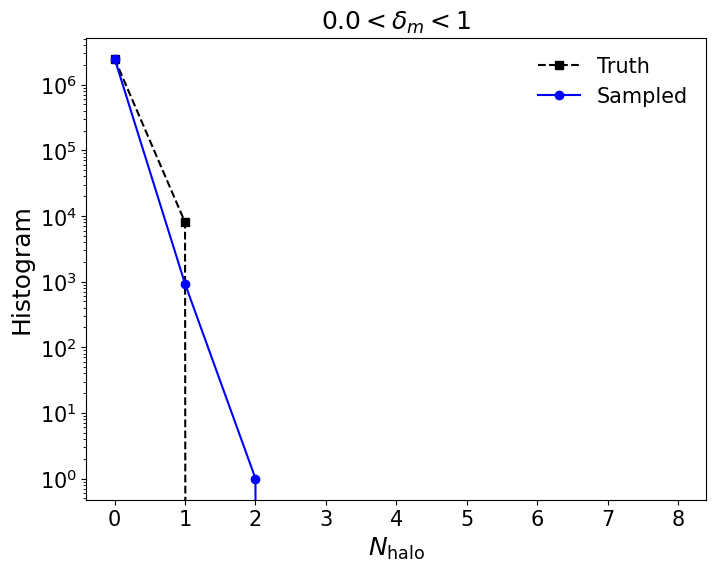

In [32]:
delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1
# delta_min_p, delta_max_p =1.0, 1.5
delta_min_p, delta_max_p = 0.0, 1
# delta_min_p, delta_max_p = 2, 5
# delta_min_p, delta_max_p = -0.5, -0.0
# delta_min_p, delta_max_p = 1.0, 2.0
indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
pl.figure(figsize=(8,6))
bin_cents = np.array([0,1,2,3,4,5,6,7,8])
bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
bin_edges = np.insert(bin_edges,0, -0.5)
bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] + 0.5)
hist_truth, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
# _ = pl.hist(df_Nh_truth[indsel_dp].flatten(), histtype='step', bins=[0,1,2,3,4,5,6,7,8], label='Truth')
pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label='Truth')
hist_samp, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
# _ = pl.hist(, bins=[0,1,2,3,4,5,6,7,8], label='Sampled')
pl.plot(bin_cents, hist_samp, marker='o', color='b', ls='-', label='Sampled')
pl.yscale('log')
pl.legend(fontsize=15, frameon=False)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.xlabel(r'$N_{\rm halo}$', size=18)
pl.ylabel('Histogram', size=18)
pl.title(str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)






In [150]:
# delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1
# # delta_min_p, delta_max_p = -1.0, -0.5
# # delta_min_p, delta_max_p = -0.5, -0.0
# delta_min_p, delta_max_p = -1.0, 100.0
# # delta_min_p, delta_max_p = 0.0, 10.0
# # delta_min_p, delta_max_p = -1.0, 50.0
# # delta_min_p, delta_max_p = 3.0, 10.0
# indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
# pl.figure(figsize=(8,6))
# bin_cents = np.linspace(13.3, 16.0, 10)
# bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
# delta_b = 0.5*(bin_cents[1] - bin_cents[0])
# bin_edges = np.insert(bin_edges,0, bin_cents[0] - delta_b)
# bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] - delta_b)

# idim = 0
# M_idim_truth = df_Mh_all_truth[..., idim]

# hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges)
# # _ = pl.hist(df_Nh_truth[indsel_dp].flatten(), histtype='step', bins=[0,1,2,3,4,5,6,7,8], label='Truth')
# pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label='Truth')

# M_idim_samp = save_subvol_Mtot[..., idim]
# hist_samp, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges)
# # _ = pl.hist(, bins=[0,1,2,3,4,5,6,7,8], label='Sampled')
# pl.plot(bin_cents, hist_samp, marker='o', color='b', ls='-', label='Sampled')
# pl.yscale('log')
# pl.legend(fontsize=15, frameon=False)
# pl.tick_params(axis='both', which='major', labelsize=15)
# pl.tick_params(axis='both', which='minor', labelsize=15)
# pl.xlabel(r'$M$' + str(idim + 1), size=18)
# pl.ylabel('Histogram', size=18)
# pl.title(str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)






In [151]:
# # make a four panel figure with idim going from 0 to 3 in the rows:

# delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1
# delta_min_p, delta_max_p = -1.0, 20.0
# indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
# bin_cents = np.linspace(13.3, 16.0, 20)
# bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
# delta_b = 0.5*(bin_cents[1] - bin_cents[0])
# bin_edges = np.insert(bin_edges,0, bin_cents[0] - delta_b)
# bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] - delta_b)

# fig, ax = pl.subplots(1,4, figsize=(24,6), sharey=True, sharex=True)
# for idim in range(4):
#     M_idim_truth = df_Mh_all_truth[..., idim]
#     hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges)
#     ax[idim].plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label='Truth')
    
#     M_idim_samp = save_subvol_Mtot[..., idim]
#     hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges)
#     ax[idim].plot(bin_cents, hist_sampled, marker='o', color='b', ls='-', label='Sampled')
#     ax[idim].set_yscale('log')
#     ax[idim].tick_params(axis='both', which='major', labelsize=15)
#     ax[idim].tick_params(axis='both', which='minor', labelsize=15)
    
#     if idim == 0:
#         ax[idim].set_ylabel('Histogram', size=18)
#     ax[idim].set_xlabel(r'$M$' + str(idim + 1), size=18)



In [152]:
# pl.figure()
# # _ = pl.hist(np.random.gumbel(0.1, 0.03, 10000),bins=100)
# _ = pl.hist(np.random.weibull(0.8, 10000),bins=100)
# # pl.xscale('log')
# pl.yscale('log')


Text(0.5, 1.0, '-1.0$< \\delta_m < $50.0')

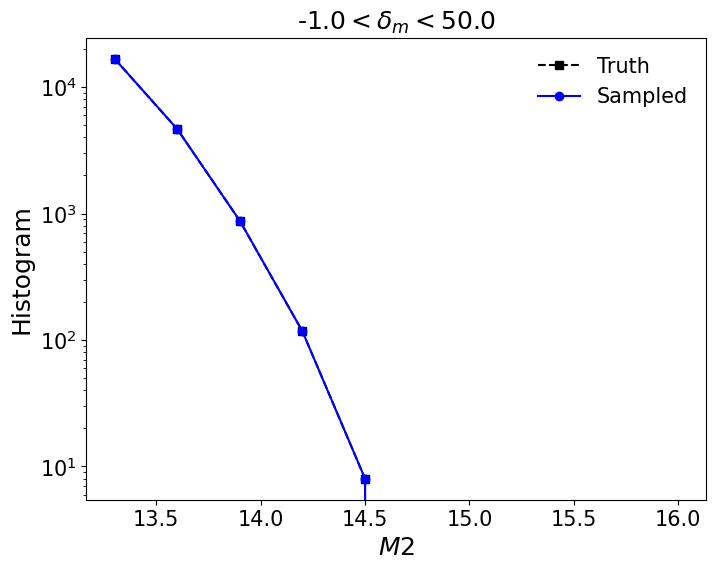

In [153]:
delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1
# delta_min_p, delta_max_p = -1.0, -0.5
# delta_min_p, delta_max_p = -0.5, -0.0
# delta_min_p, delta_max_p = -1.0, 0.0
# delta_min_p, delta_max_p = 0.0, 1.0
delta_min_p, delta_max_p = -1.0, 50.0
# delta_min_p, delta_max_p = 3.0, 10.0
indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
pl.figure(figsize=(8,6))
bin_cents = np.linspace(13.3, 16.0, 10)
bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
delta_b = 0.5*(bin_cents[1] - bin_cents[0])
bin_edges = np.insert(bin_edges,0, bin_cents[0] - delta_b)
bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] - delta_b)

idim = 1
M_idim_truth = df_Mh_all_truth[..., idim]

hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges)
# _ = pl.hist(df_Nh_truth[indsel_dp].flatten(), histtype='step', bins=[0,1,2,3,4,5,6,7,8], label='Truth')
pl.plot(bin_cents, hist_truth, marker='s', color='k', ls='--', label='Truth')

M_idim_samp = save_subvol_Mtot[..., idim]
hist_samp, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges)
# _ = pl.hist(, bins=[0,1,2,3,4,5,6,7,8], label='Sampled')
pl.plot(bin_cents, hist_samp, marker='o', color='b', ls='-', label='Sampled')
pl.yscale('log')
pl.legend(fontsize=15, frameon=False)
pl.tick_params(axis='both', which='major', labelsize=15)
pl.tick_params(axis='both', which='minor', labelsize=15)
pl.xlabel(r'$M$' + str(idim + 1), size=18)
pl.ylabel('Histogram', size=18)
pl.title(str(delta_min_p) + r'$< \delta_m < $' + str(delta_max_p), size=18)





In [154]:
# create empty arrays for Nhalos and M_halos
Nhalos = np.zeros((ns_h, ns_h, ns_h))
M_halos = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))
M_halos_truth = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))

subvol_size = ns_h // nb

ind_cart_lin = {}
ind_lin_cart = {}
jc = 0
from tqdm import tqdm
for jx in tqdm(range(nb)):
    for jy in range(nb):
        for jz in range(nb):
            # get the sub-cube
            ind_lin_cart[(jx, jy, jz)] = jc
            ind_cart_lin[jc] = [jx, jy, jz]
            jc += 1
            

# iterate over subvolumes
jc = 0
for jx in range(nb):
    for jy in range(nb):
        for jz in range(nb):
            # update Nhalos and M_halos with subvolumes
#             Nhalos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
#                    jz * subvol_size:(jz + 1) * subvol_size] = save_subvol_Nhalo[jc]

#             M_halos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
#                     jz * subvol_size:(jz + 1) * subvol_size, :] = save_subvol_Mtot[jc]

            Nhalos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                   jz * subvol_size:(jz + 1) * subvol_size] = save_subvol_Nhalo[ind_lin_cart[(jx, jy, jz)]]

            M_halos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                    jz * subvol_size:(jz + 1) * subvol_size, :] = save_subvol_Mtot[ind_lin_cart[(jx, jy, jz)]]
            
            
            jc += 1
            
            
            

100%|██████████| 8/8 [00:00<00:00, 16972.40it/s]


In [155]:
# create empty arrays for Nhalos and M_halos
Nhalos_truth_recomb = np.zeros((ns_h, ns_h, ns_h))
M_halos_truth_recomb = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))

subvol_size = ns_h // nb

ind_cart_lin = {}
ind_lin_cart = {}
jc = 0
from tqdm import tqdm
for jx in tqdm(range(nb)):
    for jy in range(nb):
        for jz in range(nb):
            # get the sub-cube
            ind_lin_cart[(jx, jy, jz)] = jc
            ind_cart_lin[jc] = [jx, jy, jz]
            jc += 1
            

# iterate over subvolumes
jc = 0
for jx in range(nb):
    for jy in range(nb):
        for jz in range(nb):
            # update Nhalos and M_halos with subvolumes
#             Nhalos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
#                    jz * subvol_size:(jz + 1) * subvol_size] = save_subvol_Nhalo[jc]

#             M_halos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
#                     jz * subvol_size:(jz + 1) * subvol_size, :] = save_subvol_Mtot[jc]

            Nhalos_truth_recomb[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                   jz * subvol_size:(jz + 1) * subvol_size] = df_Nh_truth[ind_lin_cart[(jx, jy, jz)]]

            M_halos_truth_recomb[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                    jz * subvol_size:(jz + 1) * subvol_size, :] = df_Mh_all_truth[ind_lin_cart[(jx, jy, jz)]]
            
            
            jc += 1
            

           
            


100%|██████████| 8/8 [00:00<00:00, 25712.21it/s]


(0.0, 100.0)

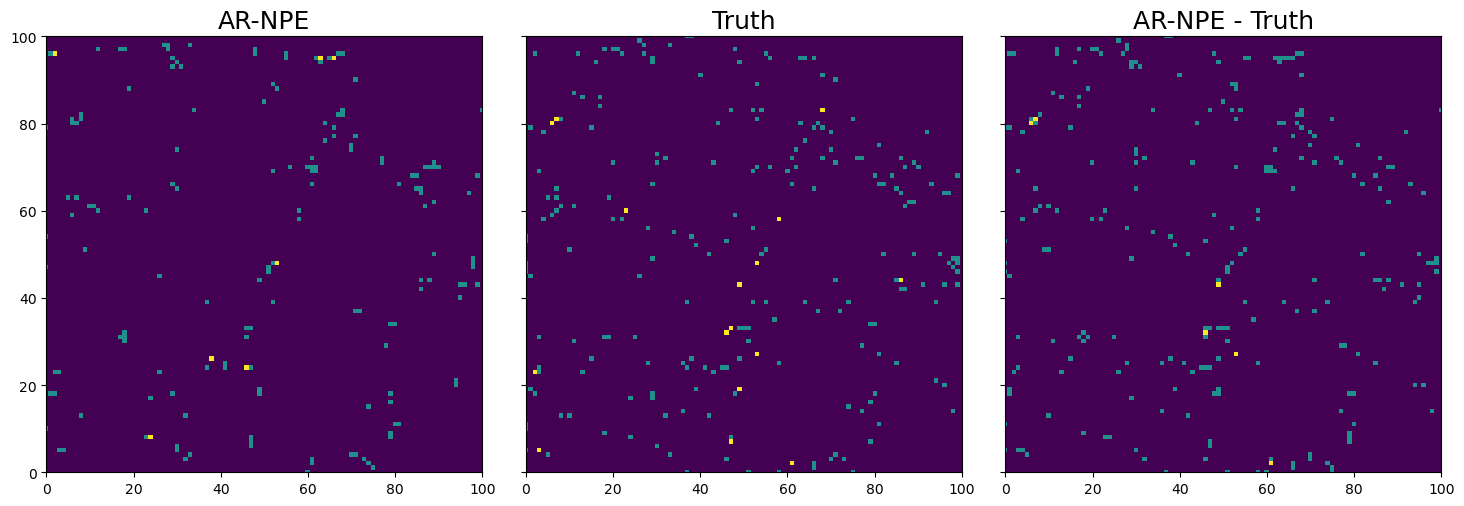

In [156]:
# Nhalos_truth_recomb.shape
# pl.figure()
# pl.imshow(np.log(np.abs(M_halos_truth_recomb[64,:,:,0] - M_halos[64,:,:,0])), origin='lower')
# # pl.imshow(np.log(np.abs(M_halos_truth_recomb[64,:,:,0] - M_halos[64,:,:,0])), origin='lower')
# pl.imshow(M_halos_truth_recomb[64,:,:,0], vmin=13, vmax=16, origin='lower')
# pl.figure()
# pl.imshow(, vmin=13, vmax=16, origin='lower')


fig, axes = pl.subplots(nrows=1, ncols=3, figsize=(18, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# axes[0].imshow(((mesh_truth.preview(axes=[0,1]))))
# axes[0].set_title('Truth', size=18)
xmin = 0
xmax = 100
axes[0].imshow(Nhalos[80,:,:], vmin=0, vmax=2, origin='lower')
axes[0].set_title('AR-NPE', size=18)
axes[0].set_xlim(xmin,xmax)
axes[0].set_ylim(xmin,xmax)

axes[1].imshow(Nhalos_truth_recomb[80,:,:], vmin=0, vmax=2, origin='lower')
axes[1].set_title('Truth', size=18)
axes[1].set_xlim(xmin,xmax)
axes[1].set_ylim(xmin,xmax)

# axes[2].imshow((np.abs(10**M_halos_truth_recomb[64,:,:,0] - 10**M_halos[64,:,:,0])/10**M_halos_truth_recomb[64,:,:,0]), vmin=0, vmax=1.0, origin='lower')
axes[2].imshow((np.abs(Nhalos_truth_recomb[80,:,:] - Nhalos[80,:,:])), vmin=0, vmax=2, origin='lower')
axes[2].set_title('AR-NPE - Truth', size=18)
axes[2].set_xlim(xmin,xmax)
axes[2].set_ylim(xmin,xmax)






            

(0.0, 4.0)

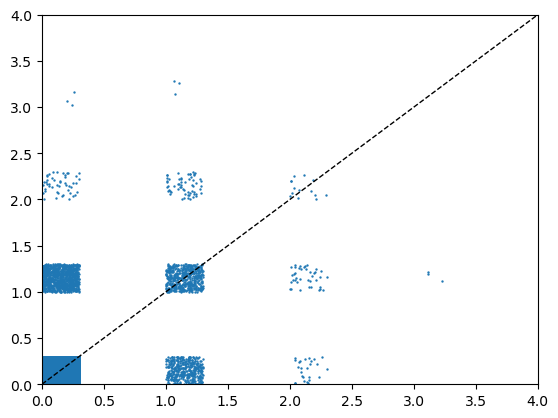

In [157]:
pl.figure()
pl.scatter(Nhalos[64,:,:].flatten() + 0.3*np.random.rand(len(Nhalos[64,:,:].flatten())), Nhalos_truth_recomb[64,:,:].flatten()+ 0.3*np.random.rand(len(Nhalos[64,:,:].flatten())), s=0.5)
pl.plot([0,4],[0,4], color='k', ls='--', lw=1)
pl.xlim(0,4)
pl.ylim(0,4)



In [158]:
# create the meshgrid
zv = 0.0
av = 1. / (1 + zv)
xall = (np.linspace(0, 1000, ns_h + 1))
xarray = av * 0.5 * (xall[1:] + xall[:-1])
yarray = np.copy(xarray)
zarray = np.copy(xarray)
x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')




In [159]:
# create the meshgrid
zv = 0.0
av = 1. / (1 + zv)
xall = (np.linspace(0, 1000, ns_h + 1))
xarray = av * 0.5 * (xall[1:] + xall[:-1])
dx = (xall[1] - xall[0])
yarray = np.copy(xarray)
zarray = np.copy(xarray)
x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')

x_h_mock, y_h_mock, z_h_mock, lgM_mock = [], [], [], []
k = 0
for jx in range(ns_h):
    for jy in range(ns_h):
        for jz in range(ns_h):
                Nh_vox = int(Nhalos[jx, jy, jz])
                if Nh_vox > 0:
                    # for jh in range(Nh_vox):
                    # x_h_mock.append(x_cy[jx, jy, jz]*np.random.rand(Nh_vox)*dx)
                    # y_h_mock.append(y_cy[jx, jy, jz]*np.random.rand(Nh_vox)*dx)
                    # z_h_mock.append(z_cy[jx, jy, jz]*np.random.rand(Nh_vox)*dx)
                    x_h_mock.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
                    y_h_mock.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
                    z_h_mock.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))
                    
                    lgM_mock.append((M_halos[jx, jy, jz, :Nh_vox]))
                    k += Nh_vox

# convert to numpy arrays
x_h_mock = np.concatenate(x_h_mock)
y_h_mock = np.concatenate(y_h_mock)
z_h_mock = np.concatenate(z_h_mock)
pos_h_mock = np.vstack((x_h_mock, y_h_mock, z_h_mock)).T
lgMass_mock = np.concatenate(lgM_mock)
# convert to float data type
pos_h_mock = pos_h_mock.astype('float32')
lgMass_mock = lgMass_mock.astype('float32')

# import numpy as np
# import h5py as h5
# with h5.File('/global/cfs/cdirs/lsst/www/shivamp/AR_NPE/run_models/mock_halo_ns' + str(ns_h) + '.h5', 'w') as f:
#     # create a new dataset and write the data to it
#     f.create_dataset('x_h', data=x_h_mock)
#     f.create_dataset('y_h', data=y_h_mock)
#     f.create_dataset('z_h', data=z_h_mock)
#     f.create_dataset('lgMass_mock', data=lgMass_mock)    
#     f.close()

    


In [160]:

# sdir='/pscratch/sd/s/spandey/quijote/Snapshot_fid/Snapshot_fid_density'
# # load the halo data
# fname = sdir + '/' + str(0) + '/halo_data_dict_' + str(ns_h) + '.pk'
# df_h = pk.load(open(fname, 'rb'))
# # This has information on the halo mass for all the halos in the voxel
# df_Mh_all_truth = df_h['M_halos']
# df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
# # This has information on the number of halos in the voxel
# df_Nh_truth = df_h['N_halos']

# df_Mh_all_truth_comb, df_Nh_truth_comb = df_h['M_halos_combined'], df_h['N_halos_combined']

sdir='/pscratch/sd/s/spandey/quijote/data_NGP_self'
# load the halo data
fname = sdir + '/' + str(0) + '/halos_subvol_res_' + str(ns_h) + '_z=0.pk'
df_h = pk.load(open(fname, 'rb'))
# This has information on the halo mass for all the halos in the voxel
df_Mh_all_truth = df_h['M_halos']
df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
# This has information on the number of halos in the voxel
df_Nh_truth = df_h['N_halos']

fname = sdir + '/' + str(0) + '/halos_full_res_' + str(ns_h) + '_z=0.pk'
df_h = pk.load(open(fname, 'rb'))
df_Mh_all_truth_comb, df_Nh_truth_comb = df_h['M_halos_combined'], df_h['N_halos_combined']




# create the meshgrid
zv = 0.0
av = 1. / (1 + zv)
xall = (np.linspace(0, 1000, ns_h + 1))
xarray = av * 0.5 * (xall[1:] + xall[:-1])
dx = (xall[1] - xall[0])
yarray = np.copy(xarray)
zarray = np.copy(xarray)
x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')

x_h_truth, y_h_truth, z_h_truth, lgM_truth = [], [], [], []
for jx in range(ns_h):
    for jy in range(ns_h):
        for jz in range(ns_h):
                Nh_vox = int(df_Nh_truth_comb[jx, jy, jz])
                if Nh_vox > 0:
                    # for jh in range(Nh_vox):
                    # x_h_mock.append(x_cy[jx, jy, jz]*np.random.rand(Nh_vox)*dx)
                    # y_h_mock.append(y_cy[jx, jy, jz]*np.random.rand(Nh_vox)*dx)
                    # z_h_mock.append(z_cy[jx, jy, jz]*np.random.rand(Nh_vox)*dx)
                    x_h_truth.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
                    y_h_truth.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
                    z_h_truth.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))
                    
                    lgM_truth.append((df_Mh_all_truth_comb[jx, jy, jz, :Nh_vox]))

# convert to numpy arrays
x_h_truth = np.concatenate(x_h_truth)
y_h_truth = np.concatenate(y_h_truth)
z_h_truth = np.concatenate(z_h_truth)
pos_h_truth = np.vstack((x_h_truth, y_h_truth, z_h_truth)).T
lgMass_truth = np.concatenate(lgM_truth)
# convert to float data type
pos_h_truth = pos_h_truth.astype('float32')
lgMass_truth = lgMass_truth.astype('float32')

import numpy as np
import h5py as h5
with h5.File('/global/cfs/cdirs/lsst/www/shivamp/AR_NPE/FINAL_run_models/truth_halo_ns' + str(ns_h) + '.h5', 'w') as f:
    # create a new dataset and write the data to it
    f.create_dataset('x_h', data=x_h_truth)
    f.create_dataset('y_h', data=y_h_truth)
    f.create_dataset('z_h', data=z_h_truth)
    f.create_dataset('lgMass_mock', data=lgMass_truth)    
    f.close()

    






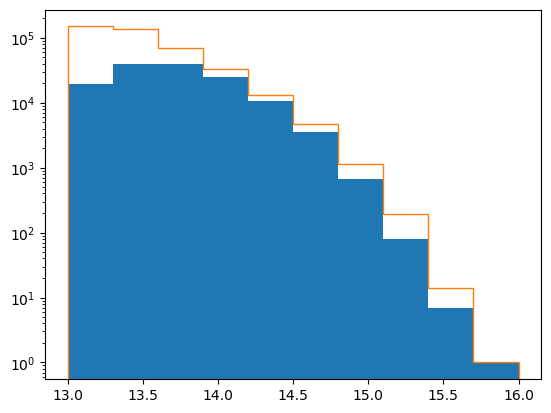

In [161]:
# ns_h
# pos_h_mock
pl.figure()
_ = pl.hist(lgMass_mock, range=(13, 16))
_ = pl.hist(lgMass_truth, range=(13, 16),histtype='step')
pl.yscale('log')






In [162]:
# !pip install Pylians




In [163]:
# import MAS_library as MASL
import sys, os
from tqdm import tqdm
import readfof
import numpy as np
import pickle as pk 
# from nbodykit.lab import *
import h5py as h5
import numpy as np
import Pk_library as PKL
import MAS_library as MASL



In [191]:
import readfof
import MAS_library as MASL
snap_dir_base='/pscratch/sd/s/spandey/quijote/Halos/fiducial'
# load the corresponding halo catalogue
snapdir = snap_dir_base + '/' + str(0)  #folder hosting the catalogue
snapnum=4
# determine the redshift of the catalogue
# z_dict = {4: 0.0, 3: 0.5, 2: 1.0, 1: 2.0, 0: 3.0}
# redshift = z_dict[snapnum]

# read the halo catalogue
FoF = readfof.FoF_catalog(snapdir, snapnum, long_ids=False, swap=False, SFR=False, read_IDs=False)

# get the properties of the halos
pos_h_truth = FoF.GroupPos / 1e3  #Halo positions in Mpc/h
mass_truth = FoF.GroupMass * 1e10  #Halo masses in Msun/h

lgMass_truth = np.log10(mass_truth)

Mmin_Pk, Mmax_Pk = 13.5, 100.0
# Mmin_Pk, Mmax_Pk = 14.0, 14.5
# Mmin_Pk, Mmax_Pk = 13.5, 14.0
# Mmin_Pk, Mmax_Pk = 14.5, 100.0
# Mmin_Pk, Mmax_Pk = 13, 16
indsel_Pk_truth = np.where((lgMass_truth > Mmin_Pk) & (lgMass_truth < Mmax_Pk))[0]
print(len(indsel_Pk_truth))
# density field parameters
grid    = ns_h    #the 3D field will have grid x grid x grid voxels
BoxSize = 1000.0 #Mpc/h ; size of box
MAS     = 'CIC'  #mass-assigment scheme
verbose = True   #print information on progress


mesh_truth = np.zeros((grid, grid, grid), dtype=np.float32)
pos_truth = pos_h_truth[indsel_Pk_truth,...]
MASL.MA(pos_truth, mesh_truth, BoxSize, MAS)
mesh_truth /= np.mean(mesh_truth, dtype=np.float64);  mesh_truth -= 1.0
Pk_truth = PKL.Pk(mesh_truth, BoxSize, axis=0, MAS=MAS, threads=1)

# df_nbkit = {}
# lgM_samp = df_samp['lgM_samp_all_f']
# df_nbkit['Position'] = np.vstack((df_samp['x_samp_all'], df_samp['y_samp_all'], df_samp['z_samp_all'])).T
# df_nbkit['Position'] = pos_h_truth[indsel_Pk_truth,...]
# np.vstack((df_samp['x_samp_all'], df_samp['y_samp_all'], df_samp['z_samp_all'])).T.shape
# from nbodykit.source.catalog import ArrayCatalog
# cat = ArrayCatalog(df_nbkit, BoxSize=1000.0)
# mesh_truth = cat.to_mesh(window='nearest', Nmesh=grid, compensated=False, position='Position')
# mesh_truth = cat.to_mesh(window='cic', Nmesh=grid, compensated=False, position='Position')
# r = FFTPower(mesh_truth, mode='1d', dk=0.05)
# Pk_truth = r.power









155640

Computing power spectrum of the field...
Time to complete loop = 0.83
Time taken = 0.92 seconds


In [192]:
import numpy as np
import h5py as h5

with h5.File('/global/cfs/cdirs/lsst/www/shivamp/AR_NPE/FINAL_run_models/truth_halo_ns' + str(ns_h) + '.h5', 'r') as df:
    pos_h_truth = np.vstack((df['x_h'][()],df['y_h'][()],df['z_h'][()])).T
    lgMass_truth = df['lgMass_mock'][()]
indsel_Pk_truth = np.where((lgMass_truth > Mmin_Pk) & (lgMass_truth < Mmax_Pk))[0]
# print(len(indsel_Pk_truth))
# df_nbkit = {}
# df_nbkit['Position'] = pos_h_truth[indsel_Pk_truth,...]
# from nbodykit.source.catalog import ArrayCatalog
# cat = ArrayCatalog(df_nbkit, BoxSize=1000.0)
# mesh_truth2 = cat.to_mesh(window='nearest', Nmesh=grid, compensated=False, position='Position')
# mesh_truth2 = cat.to_mesh(window='cic', Nmesh=grid, compensated=False, position='Position')
# r = FFTPower(mesh_truth2, mode='1d', dk=0.05)
# Pk_truth2 = r.power

mesh_truth2 = np.zeros((grid, grid, grid), dtype=np.float32)
pos_truth2 = (pos_h_truth[indsel_Pk_truth,...]).astype(np.float32)
MASL.MA(pos_truth2, mesh_truth2, BoxSize, MAS)
mesh_truth2 /= np.mean(mesh_truth2, dtype=np.float64);  mesh_truth2 -= 1.0
Pk_truth2 = PKL.Pk(mesh_truth2, BoxSize, axis=0, MAS=MAS, threads=1)








Computing power spectrum of the field...
Time to complete loop = 0.81
Time taken = 0.88 seconds


In [193]:
import numpy as np
import h5py as h5
# df = h5.File('/global/cfs/cdirs/lsst/www/shivamp/AR_NPE/run_models/mock_halo_ns256.h5', 'r')
# pos_h_mock = np.vstack((df['x_h'][()],df['y_h'][()],df['z_h'][()])).T
# lgMass_mock = df['lgMass_mock'][()]


indsel_Pk_mock = np.where((lgMass_mock > Mmin_Pk) & (lgMass_mock < Mmax_Pk))[0]
print(len(indsel_Pk_mock))
# df_nbkit = {}
# df_nbkit['Position'] = pos_h_mock[indsel_Pk_mock,...]

# from nbodykit.source.catalog import ArrayCatalog
# cat = ArrayCatalog(df_nbkit, BoxSize=1000.0)
# # mesh_mock = cat.to_mesh(window='nearest', Nmesh=grid, compensated=False, position='Position')
# mesh_mock = cat.to_mesh(window='cic', Nmesh=grid, compensated=False, position='Position')
# r = FFTPower(mesh_mock, mode='1d', dk=0.05)
# Pk_mock = r.power


mesh_mock = np.zeros((grid, grid, grid), dtype=np.float32)
pos_mock = (pos_h_mock[indsel_Pk_mock,...]).astype(np.float32)
MASL.MA(pos_mock, mesh_mock, BoxSize, MAS)
mesh_mock /= np.mean(mesh_mock, dtype=np.float64);  mesh_mock -= 1.0
Pk_mock = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=MAS, threads=1)







93865

Computing power spectrum of the field...
Time to complete loop = 0.83
Time taken = 0.91 seconds


In [194]:
# Pk_mock.Pk.shape


In [195]:
# r = FFTPower(mesh_truth, second=mesh_mock, mode='1d', dk=0.05)
# Pk_mockxtruth = r.power 
Pk_mockxtruth = PKL.XPk([mesh_truth,mesh_mock], BoxSize, axis=0, MAS=[MAS, MAS], threads=1)


# r = FFTPower(mesh_truth2, second=mesh_mock, mode='1d', dk=0.05)
# Pk_mockxtruth2 = r.power
Pk_mockxtruth2 = PKL.XPk([mesh_truth2,mesh_mock], BoxSize, axis=0, MAS=[MAS, MAS], threads=1)
# r = FFTPower(mesh_mock, second=mesh_truth2, mode='1d', dk=0.05)
# Pk_mockxtruth2 = r.power


# r = FFTPower(mesh_truth2, second=mesh_mock, mode='1d', dk=0.05)
# Pk_mockxtruth2 = r.power
# r = FFTPower(mesh_truth, second=mesh_truth2, mode='1d', dk=0.05)
# Pk_truthxtruth2 = r.power
Pk_truthxtruth2 = PKL.XPk([mesh_truth2,mesh_truth], BoxSize, axis=0, MAS=[MAS, MAS], threads=1)







Computing power spectra of the fields...
Time FFTS = 0.20
Time loop = 0.74
Time taken = 0.93 seconds

Computing power spectra of the fields...
Time FFTS = 0.20
Time loop = 0.74
Time taken = 0.94 seconds

Computing power spectra of the fields...
Time FFTS = 0.20
Time loop = 0.74
Time taken = 0.94 seconds


In [196]:

# mesh_mock
# mesh_truth2

Text(0.5, 1.0, 'AR-NPE')

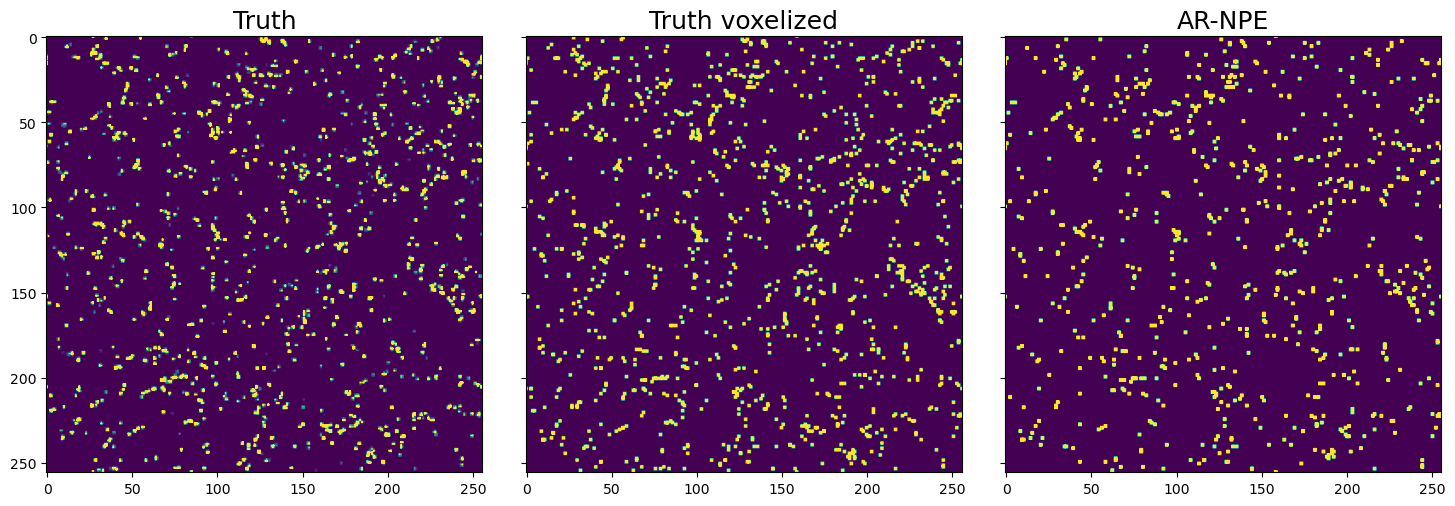

In [197]:
fig, axes = pl.subplots(nrows=1, ncols=3, figsize=(18, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)

# axes[0].imshow(((mesh_truth.preview(axes=[0,1]))), vmin=-1.0, vmax=200.0)
axes[0].imshow(((mesh_truth[64,...])), vmin=-1.0, vmax=10.0)
axes[0].set_title('Truth', size=18)
# axes[0].imshow(((mesh_mock.preview(axes=[0,1]) - mesh_truth2.preview(axes=[0,1]))), vmin=-1.0, vmax=200.0)
# axes[0].set_title('AR-NPE', size=18)

# axes[1].imshow(((mesh_truth2.preview(axes=[0,1]))), vmin=-1.0, vmax=200.0)
axes[1].imshow(((mesh_truth2[64,...])), vmin=-1.0, vmax=10.0)
axes[1].set_title('Truth voxelized', size=18)
# axes[2].imshow(((mesh_mock.preview(axes=[0,1]))), vmin=-1.0, vmax=200.0)
axes[2].imshow(((mesh_mock[64,...])), vmin=-1.0, vmax=10.0)
axes[2].set_title('AR-NPE', size=18)






(0.0, 32.0)

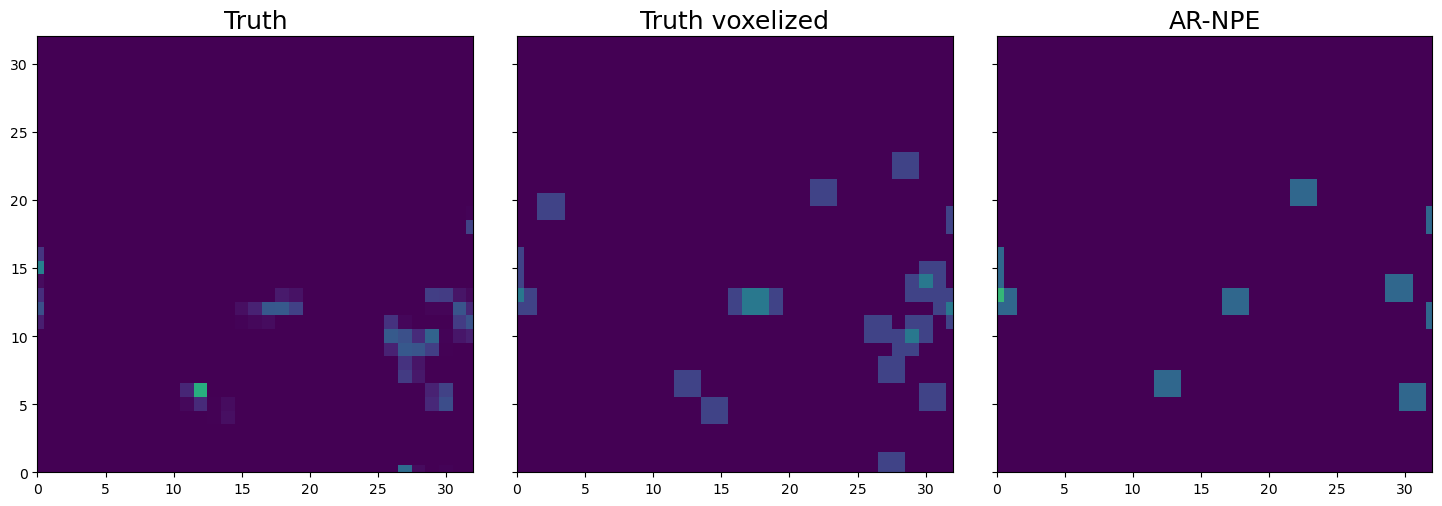

In [198]:
fig, axes = pl.subplots(nrows=1, ncols=3, figsize=(18, 8), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)
xmin = 0
xmax = 32
# axes[0].imshow(((mesh_truth.preview(axes=[0,1]))))
axes[0].imshow(((mesh_truth[64,...])))
axes[0].set_title('Truth', size=18)
axes[0].set_xlim(xmin,xmax)
axes[0].set_ylim(xmin,xmax)
# axes[1].imshow(((mesh_truth2.preview(axes=[0,1]))))
axes[1].imshow(((mesh_truth2[64,...])))
axes[1].set_title('Truth voxelized', size=18)
axes[1].set_xlim(xmin,xmax)
axes[2].set_ylim(xmin,xmax)
# axes[2].imshow(((mesh_mock.preview(axes=[0,1]))))
axes[2].imshow(((mesh_mock[64,...])))
axes[2].set_title('AR-NPE', size=18)
axes[2].set_xlim(xmin,xmax)
axes[2].set_ylim(xmin,xmax)




In [199]:
# import matplotlib.pyplot as plt

# fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 18), sharex=True)
# fig.subplots_adjust(wspace=0.1, hspace=0.1)
# # First subplot
# axes[0].loglog(Pk_truth['k'], Pk_truth['power'].real - Pk_truth.attrs['shotnoise'], label='Truth', color='b', ls='', marker='s', lw=2.0)
# axes[0].loglog(Pk_truth2['k'], Pk_truth2['power'].real - Pk_truth2.attrs['shotnoise'], label='Truth-voxelized', color='r', ls='', marker='D', lw=2.0)
# axes[0].loglog(Pk_mock['k'], (Pk_mock['power'].real - Pk_mock.attrs['shotnoise']), label='AR-NPE', color='k', ls='-', marker='o', lw=2.0)


# # axes[0].loglog(Pk_truth['k'], Pk_truth['power'].real, label='Truth', color='b', ls='', marker='s', lw=2.0)
# # axes[0].loglog(Pk_truth2['k'], Pk_truth2['power'].real, label='Truth-voxelized', color='r', ls='', marker='D', lw=2.0)
# # axes[0].loglog(Pk_mock['k'], (Pk_mock['power'].real), label='AR-NPE', color='k', ls='-', marker='o', lw=2.0)

# axes[0].legend(fontsize=16, loc='lower left')
# # axes[0].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=22)
# axes[0].set_ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]", size=18)
# # axes[0].set_title(str(Mmin_Pk) + r'$< \log(M) <$' + str(Mmax_Pk), size=18)
# axes[0].tick_params(axis='both', labelsize=15)
# # Second subplot
# # axes[1].plot(Pk_mock['k'], (Pk_mock['power'].real - Pk_mock.attrs['shotnoise']) / (Pk_truth['power'].real  - Pk_truth.attrs['shotnoise'] ), label='AR-NPE/Truth', color='b', ls='-', marker='o', lw=2.0)
# # axes[1].plot(Pk_mock['k'], (Pk_mock['power'].real - Pk_mock.attrs['shotnoise']) / (Pk_truth2['power'].real - Pk_truth2.attrs['shotnoise'] ), label='AR-NPE/Truth-voxelized', color='r', ls='--', marker='D', lw=2.0)

# axes[1].plot(Pk_mock['k'], (Pk_mock['power'].real) / (Pk_truth['power'].real), label='AR-NPE/Truth', color='b', ls='-', marker='o', lw=2.0)
# axes[1].plot(Pk_mock['k'], (Pk_mock['power'].real) / (Pk_truth2['power'].real), label='AR-NPE/Truth-voxelized', color='r', ls='--', marker='D', lw=2.0)


# axes[1].legend(fontsize=16, loc='lower left')
# # axes[1].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=22)
# axes[1].set_ylabel(r"$P(k)$ ratio", size=18)
# axes[1].axhline(1.0, ls='--', color='k')
# axes[1].set_ylim(0.8, 1.2)
# axes[1].tick_params(axis='both', labelsize=15)
# # axes[1].set_title(str(Mmin_Pk) + r'$< \log(M) <$' + str(Mmax_Pk), size=20)

# # Third subplot
# axes[2].plot(Pk_mockxtruth['k'], (Pk_mockxtruth['power'].real) / (((Pk_mock['power'].real) * (Pk_truth['power'].real)) ** 0.5), label='Truth x AR-NPE', color='b', ls='-', marker='s', lw=2.0)
# axes[2].plot(Pk_mockxtruth2['k'], (Pk_mockxtruth2['power'].real) / (((Pk_mock['power'].real) * (Pk_truth2['power'].real)) ** 0.5), label='Truth-voxelized x AR-NPE', color='r', ls='--', marker='D', lw=2.0)
# # axes[2].plot(Pk_truthxtruth2['k'], (Pk_truthxtruth2['power'].real) / (((Pk_truth['power'].real) * (Pk_truth2['power'].real)) ** 0.5), label='Truth-voxelized x AR-NPE', color='r', ls='--', marker='s', lw=2.0)
# # axes[2].set_ylim(0.9, 1.1)
# axes[2].axhline(1.0, ls='--', color='k')
# axes[2].set_xscale('log')
# axes[2].legend(fontsize=16)
# axes[2].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=18)
# axes[2].set_ylabel(r"Cross-coeff", size=18)
# axes[2].tick_params(axis='both', labelsize=15)
# plt.tight_layout()
# # plt.savefig('/global/cfs/cdirs/lsst/www/shivamp/AR_NPE/figs/power_comp_ns_' + str(ns_h) + '_lgM' + str(Mmin_Pk) + '_' + str(Mmax_Pk) + '.png', dpi=300) 

                   

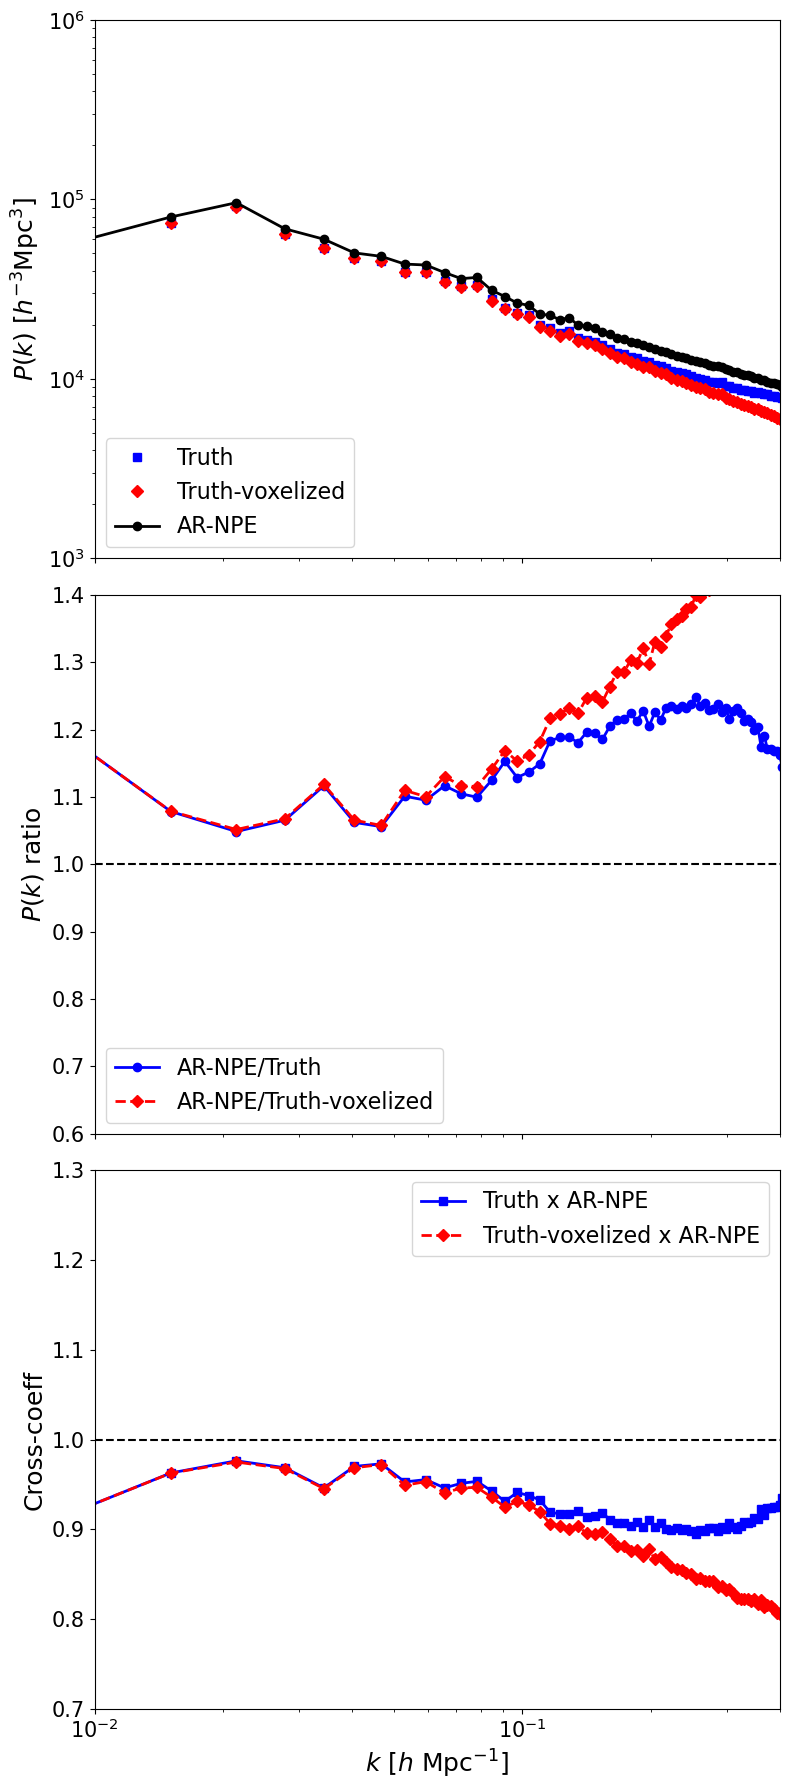

In [200]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 18), sharex=True)
fig.subplots_adjust(wspace=0.1, hspace=0.1)
# First subplot
axes[0].loglog(Pk_truth.k3D, Pk_truth.Pk[:,0], label='Truth', color='b', ls='', marker='s', lw=2.0)
axes[0].loglog(Pk_truth2.k3D, Pk_truth2.Pk[:,0], label='Truth-voxelized', color='r', ls='', marker='D', lw=2.0)
axes[0].loglog(Pk_mock.k3D, Pk_mock.Pk[:,0], label='AR-NPE', color='k', ls='-', marker='o', lw=2.0)
# axes[0].set_ylim(1e3, 1e5)
axes[0].set_ylim(1e3, 1e6)

# axes[0].loglog(Pk_truth['k'], Pk_truth['power'].real, label='Truth', color='b', ls='', marker='s', lw=2.0)
# axes[0].loglog(Pk_truth2['k'], Pk_truth2['power'].real, label='Truth-voxelized', color='r', ls='', marker='D', lw=2.0)
# axes[0].loglog(Pk_mock['k'], (Pk_mock['power'].real), label='AR-NPE', color='k', ls='-', marker='o', lw=2.0)

axes[0].legend(fontsize=16, loc='lower left')
# axes[0].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=22)
axes[0].set_ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]", size=18)
# axes[0].set_title(str(Mmin_Pk) + r'$< \log(M) <$' + str(Mmax_Pk), size=18)
axes[0].tick_params(axis='both', labelsize=15)
# Second subplot
# axes[1].plot(Pk_mock['k'], (Pk_mock['power'].real - Pk_mock.attrs['shotnoise']) / (Pk_truth['power'].real  - Pk_truth.attrs['shotnoise'] ), label='AR-NPE/Truth', color='b', ls='-', marker='o', lw=2.0)
# axes[1].plot(Pk_mock['k'], (Pk_mock['power'].real - Pk_mock.attrs['shotnoise']) / (Pk_truth2['power'].real - Pk_truth2.attrs['shotnoise'] ), label='AR-NPE/Truth-voxelized', color='r', ls='--', marker='D', lw=2.0)

axes[1].plot(Pk_mock.k3D, Pk_mock.Pk[:,0]/ Pk_truth.Pk[:,0], label='AR-NPE/Truth', color='b', ls='-', marker='o', lw=2.0)
axes[1].plot(Pk_mock.k3D, Pk_mock.Pk[:,0]/ Pk_truth2.Pk[:,0], label='AR-NPE/Truth-voxelized', color='r', ls='--', marker='D', lw=2.0)


axes[1].legend(fontsize=16, loc='lower left')
# axes[1].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=22)
axes[1].set_ylabel(r"$P(k)$ ratio", size=18)
axes[1].axhline(1.0, ls='--', color='k')
# axes[1].set_ylim(0.8, 1.2)
axes[1].set_ylim(0.6, 1.4)
axes[1].tick_params(axis='both', labelsize=15)
# axes[1].set_title(str(Mmin_Pk) + r'$< \log(M) <$' + str(Mmax_Pk), size=20)

# Third subplot
# axes[2].plot(Pk_mockxtruth['k'], (Pk_mockxtruth['power'].real) / (((Pk_mock['power'].real) * (Pk_truth['power'].real)) ** 0.5), label='Truth x AR-NPE', color='b', ls='-', marker='s', lw=2.0)
# axes[2].plot(Pk_mockxtruth2['k'], (Pk_mockxtruth2['power'].real) / (((Pk_mock['power'].real) * (Pk_truth2['power'].real)) ** 0.5), label='Truth-voxelized x AR-NPE', color='r', ls='--', marker='D', lw=2.0)
axes[2].plot(Pk_mockxtruth.k3D, (Pk_mockxtruth.Pk[:,0,0]) / (((Pk_mock.Pk[:,0]) * (Pk_truth.Pk[:,0])) ** 0.5), label='Truth x AR-NPE', color='b', ls='-', marker='s', lw=2.0)
axes[2].plot(Pk_mockxtruth2.k3D, (Pk_mockxtruth2.Pk[:,0,0]) / (((Pk_mock.Pk[:,0]) * (Pk_truth2.Pk[:,0])) ** 0.5), label='Truth-voxelized x AR-NPE', color='r', ls='--', marker='D', lw=2.0)


# axes[2].plot(Pk_truthxtruth2['k'], (Pk_truthxtruth2['power'].real) / (((Pk_truth['power'].real) * (Pk_truth2['power'].real)) ** 0.5), label='Truth-voxelized x AR-NPE', color='r', ls='--', marker='s', lw=2.0)
# axes[2].set_ylim(0.9, 1.1)
axes[2].set_ylim(0.7, 1.3)
axes[2].axhline(1.0, ls='--', color='k')
axes[2].set_xscale('log')
axes[2].legend(fontsize=16)
axes[2].set_xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]", size=18)
axes[2].set_ylabel(r"Cross-coeff", size=18)
axes[2].tick_params(axis='both', labelsize=15)
axes[2].set_xlim(0.01, 0.4)
plt.tight_layout()
# plt.savefig('/global/cfs/cdirs/lsst/www/shivamp/AR_NPE/figs/power_comp_ns_' + str(ns_h) + '_lgM' + str(Mmin_Pk) + '_' + str(Mmax_Pk) + '.png', dpi=300) 
# plt.savefig('/global/cfs/cdirs/lsst/www/shivamp/AR_NPE/figs/power_comp_ns_' + str(ns_h) + '_lgM' + str(Mmin_Pk) + '_' + str(Mmax_Pk) + '.png', dpi=300) 


                   

In [201]:
(((Pk_mock.Pk[:,0]) * (Pk_truth.Pk[:,0])) ** 0.5).shape

(221,)

In [ ]:
Pk_mockxtruth.k3D.shape